In [1]:
# Import des bibliothèques de base pour la manipulation des données et les visualisations
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Import des bibliothèques de traitement de texte
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from bs4 import BeautifulSoup
import re
import os

# Import des bibliothèques pour la modélisation et le traitement de texte avancé
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
import sentence_transformers
from sentence_transformers import SentenceTransformer
import torch
import itertools
import gensim

# Import des bibliothèques pour le prétraitement et la modélisation des données
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.multioutput import ClassifierChain
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import LatentDirichletAllocation
import sklearn.metrics as metrics
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Import des bibliothèques pour la visualisation de modèles et l'affichage dans Jupyter Notebook
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
from IPython.core.display import display, HTML

# Import des bibliothèques pour la sauvegarde et le chargement de modèles
import pickle
from gensim.models import FastText
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

# Import des bibliothèques pour l'évaluation des modèles
from sklearn.metrics import classification_report
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, f1_score

# Import des bibliothèques pour le suivi des expériences de machine learning
import mlflow
import mlflow.sklearn
import mlflow.pytorch
import mlflow.tensorflow

# Import des bibliothèques pour le traitement du langage naturel avec Transformers
from transformers import BertTokenizer, BertModel

# Import des bibliothèques pour l'utilisation de TensorFlow et TensorFlow Hub
import tensorflow_hub as hub
import tensorflow as tf


C:\Users\ouedraogo080976\AppData\Local\anaconda\Lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


C:\Users\ouedraogo080976\AppData\Local\Temp\ipykernel_20632\1184527746.py:39: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
# Téléchargement de la ressource nécessaire pour nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ouedraogo080976\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ouedraogo080976\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\ouedraogo080976\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ouedraogo080976\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
data = pd.read_csv('QueryResults.csv')
data.shape

(50000, 8)

In [4]:
##data=data.loc[:700]

### Filtrage du jeu de données avec les Top 10 Tags

In [5]:
# Étape 1 : Conserver les 10 tags les plus présents
Tags = {}

# Parcours des lignes et comptage des tags
for i, s in data.iterrows():
    chaine = s['Tags']
    chaine = chaine[1:-1]  # Enlever les caractères "<" et ">"
    elements = chaine.split("><")  # Séparer les tags
    
    for element in elements:
        if element in Tags:
            Tags[element] += 1
        else:
            Tags[element] = 1

In [6]:
# Convertir le dictionnaire en DataFrame et trier par fréquence
tags_df = pd.DataFrame(list(Tags.items()), columns=['Tag', 'Count']).sort_values(by='Count', ascending=False)

In [7]:
tags_df

,Tag,Count
46,java,5919
59,python,5465
191,javascript,5239
19,c++,4110
0,c#,3789
...,...,...
12043,unsubscribe,1
12041,return-by-reference,1
12038,angular2-nativescript,1
12036,reliable-multicast,1


In [8]:
# Conserver les 10 tags les plus fréquents
top_10_tags = tags_df.head(10)['Tag'].tolist()

C:\Users\ouedraogo080976\AppData\Local\anaconda\Lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
C:\Users\ouedraogo080976\AppData\Local\anaconda\Lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
C:\Users\ouedraogo080976\AppData\Local\anaconda\Lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


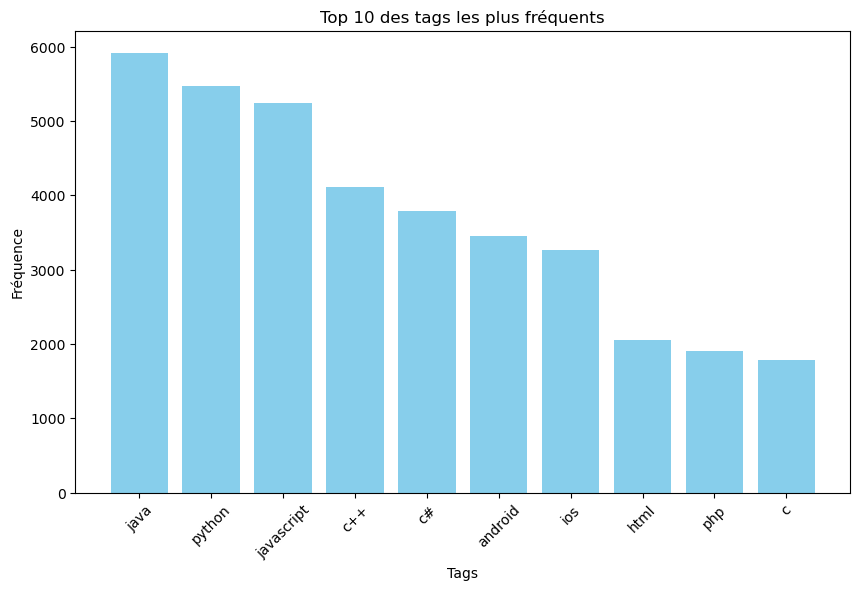

In [9]:
# Conserver les 10 tags les plus fréquents
top_10_tags = tags_df.head(10)

# Visualisation des fréquences des tags sous forme de graphique à barres
plt.figure(figsize=(10, 6))
plt.bar(top_10_tags['Tag'], top_10_tags['Count'], color='skyblue')
plt.xlabel('Tags')
plt.ylabel('Fréquence')
plt.title('Top 10 des tags les plus fréquents')
plt.xticks(rotation=45)
plt.show()

### Nettoyage du texte

In [10]:
def clean_text(text):
    text = BeautifulSoup(text, "html.parser").get_text()  # Supprimer les balises HTML
    text = re.sub(r'\s+', ' ', text)  # Supprimer les espaces supplémentaires
    text = re.sub(r'\W', ' ', text)  # Supprimer les caractères spéciaux
    return text.strip()

data['Title'] = data['Title'].apply(clean_text)
data['Body'] = data['Body'].apply(clean_text)

C:\Users\ouedraogo080976\AppData\Local\Temp\ipykernel_20632\381804469.py:2: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text()  # Supprimer les balises HTML


In [11]:
# Combining 'Title' and 'Body' into a new column 'TitleBody'
data['TitleBody'] = data['Title'] + "\n\n" + data['Body']

In [12]:
data['Tags'] = data['Tags'].str.replace('><',',')
data['Tags'] = data['Tags'].str.replace('>','')
data['Tags'] = data['Tags'].str.replace('<','')
data['Tags'] = data['Tags'].str.split(',')
data['Tags']

0        [c#, floating-point, type-conversion, double, ...
1        [c#, datetime, time, datediff, relative-time-s...
2        [html, browser, timezone, user-agent, timezone...
3        [performance, algorithm, language-agnostic, un...
4                        [c++, c, sockets, mainframe, zos]
                               ...                        
49995    [c#, entity-framework, unit-testing, repositor...
49996            [java, scala, jvm, kotlin, jvm-languages]
49997    [javascript, reactjs, jestjs, create-react-app...
49998    [android, android-drawable, android-resources,...
49999               [perl, time, format, timestamp, clock]
Name: Tags, Length: 50000, dtype: object

In [13]:
def filter_common_elements(s):
   
    return [el for el in s if el in top_10_tags['Tag'].tolist()]

# Update the dataframe column
data['new_tags'] = data['Tags'].apply(filter_common_elements)

### filtrer les lignes contenant uniquement des Tags

In [14]:
data= data.loc[data['new_tags'].apply(lambda x:len(x)>0)]
data

,Title,Body,Tags,Id,Score,ViewCount,FavoriteCount,AnswerCount,TitleBody,new_tags
0,How to convert Decimal to Double in C,I want to assign the decimal variable trans ...,"[c#, floating-point, type-conversion, double, ...",4,808,77425,0.0,13,How to convert Decimal to Double in C\n\nI wan...,[c#]
1,Calculate relative time in C,Given a specific DateTime value how do I disp...,"[c#, datetime, time, datediff, relative-time-s...",11,1654,203218,0.0,42,Calculate relative time in C\n\nGiven a specif...,[c#]
2,Determine a user s timezone,Is there a standard way for a web server to be...,"[html, browser, timezone, user-agent, timezone...",13,719,308769,0.0,27,Determine a user s timezone\n\nIs there a stan...,[html]
4,How to use the C socket API in C on z OS,I m having issues getting the C sockets API to...,"[c++, c, sockets, mainframe, zos]",25,176,16484,0.0,9,How to use the C socket API in C on z OS\n\n...,"[c++, c]"
6,Decoding T SQL CAST in C VB NET,Recently our site has been deluged with the re...,"[c#, sql, vb.net, ascii, hex]",109,68,6217,NaN,2,Decoding T SQL CAST in C VB NET\n\nRecently o...,[c#]
...,...,...,...,...,...,...,...,...,...,...
49992,Stop the touchstart performing too quick when ...,I m trying to figure out how to solve the tapp...,"[javascript, jquery, iphone, scroll, touchscreen]",9842587,7,12467,0.0,2,Stop the touchstart performing too quick when ...,[javascript]
49995,Unit test an Entity Framework generic reposito...,Question Problem I am not able to get a passin...,"[c#, entity-framework, unit-testing, repositor...",37843641,11,21816,0.0,1,Unit test an Entity Framework generic reposito...,[c#]
49996,How are coroutines implemented in JVM langs wi...,This question came up after reading the Loom p...,"[java, scala, jvm, kotlin, jvm-languages]",48033944,54,4427,0.0,4,How are coroutines implemented in JVM langs wi...,[java]
49997,Running test immediately after npm create reac...,Immediately after npx create react app my app ...,"[javascript, reactjs, jestjs, create-react-app...",61783449,11,763,NaN,1,Running test immediately after npm create reac...,[javascript]


In [15]:
data = data[['TitleBody','new_tags']]

In [16]:
data.head()

,TitleBody,new_tags
0,How to convert Decimal to Double in C\n\nI wan...,[c#]
1,Calculate relative time in C\n\nGiven a specif...,[c#]
2,Determine a user s timezone\n\nIs there a stan...,[html]
4,How to use the C socket API in C on z OS\n\n...,"[c++, c]"
6,Decoding T SQL CAST in C VB NET\n\nRecently o...,[c#]


### stopwords
La fonction remove_stopwords supprime les mots courants comme "the", "is", etc., des tokens

### tokenisation
La tokenisation est le processus de division du texte en unités plus petites appelées tokens, qui peuvent être des mots, des phrases ou d'autres éléments significatifs

### Lemmatisation
La lemmatisation consiste à ramener les mots à leur forme canonique ou lemmes, ce qui est utile pour normaliser le texte et réduire la dimensionnalité des données textuelles

In [17]:
# Tokenizer
def tokenizer_fct(sentence):
    sentence_clean = sentence.replace('-', ' ').replace('+', ' ').replace('/', ' ').replace('#', ' ')
    word_tokens = word_tokenize(sentence_clean)
    return word_tokens

# Stop words
stop_w = list(set(stopwords.words('english'))) + ['[', ']', ',', '.', ':', '?', '(', ')']

def stop_word_filter_fct(list_words):
    filtered_w = [w for w in list_words if not w in stop_w]
    filtered_w2 = [w for w in filtered_w if len(w) > 2]
    return filtered_w2

# lower case et alpha
def lower_start_fct(list_words):
    lw = [w.lower() for w in list_words if (not w.startswith("@")) 
                                       and (not w.startswith("http"))]
    return lw

# Lemmatizer (base d'un mot)
def lemma_fct(list_words):
    lemmatizer = WordNetLemmatizer()
    lem_w = [lemmatizer.lemmatize(w) for w in list_words]
    return lem_w

# Fonction de préparation du texte pour le bag of words (Countvectorizer et Word2Vec)
def transform_bow_fct(desc_text):
    word_tokens = tokenizer_fct(desc_text)
    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(sw)
    transf_desc_text = ' '.join(lw)
    return transf_desc_text

# Fonction de préparation du texte pour le bag of words avec lemmatization
def transform_bow_lem_fct(desc_text):
    word_tokens = tokenizer_fct(desc_text)
    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(sw)
    lem_w = lemma_fct(lw)
    transf_desc_text = ' '.join(lem_w)
    return transf_desc_text

# Fonction de préparation du texte pour le Deep learning (SBERT, USE et BERT)
def transform_dl_fct(desc_text):
    word_tokens = tokenizer_fct(desc_text)
    lw = lower_start_fct(word_tokens)
    transf_desc_text = ' '.join(lw)
    return transf_desc_text

# Appliquer les transformations
data['TitleBody_bow'] = data['TitleBody'].apply(lambda x: transform_bow_fct(x))
data['TitleBody_bow_lem'] = data['TitleBody'].apply(lambda x: transform_bow_lem_fct(x))
data['TitleBody_dl'] = data['TitleBody'].apply(lambda x: transform_dl_fct(x))

# Afficher les résultats
data.head()

C:\Users\ouedraogo080976\AppData\Local\Temp\ipykernel_20632\2748205906.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['TitleBody_bow'] = data['TitleBody'].apply(lambda x: transform_bow_fct(x))
C:\Users\ouedraogo080976\AppData\Local\Temp\ipykernel_20632\2748205906.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['TitleBody_bow_lem'] = data['TitleBody'].apply(lambda x: transform_bow_lem_fct(x))
C:\Users\ouedraogo080976\AppData\Local\Temp\ipykernel_20632\2748205906.py:54: SettingWithCopyWar

,TitleBody,new_tags,TitleBody_bow,TitleBody_bow_lem,TitleBody_dl
0,How to convert Decimal to Double in C\n\nI wan...,[c#],how convert decimal double want assign decimal...,how convert decimal double want assign decimal...,how to convert decimal to double in c i want t...
1,Calculate relative time in C\n\nGiven a specif...,[c#],calculate relative time given specific datetim...,calculate relative time given specific datetim...,calculate relative time in c given a specific ...
2,Determine a user s timezone\n\nIs there a stan...,[html],determine user timezone standard way web serve...,determine user timezone standard way web serve...,determine a user s timezone is there a standar...
4,How to use the C socket API in C on z OS\n\n...,"[c++, c]",how use socket api issues getting sockets api ...,how use socket api issue getting socket api wo...,how to use the c socket api in c on z os i m h...
6,Decoding T SQL CAST in C VB NET\n\nRecently o...,[c#],decoding sql cast net recently site deluged re...,decoding sql cast net recently site deluged re...,decoding t sql cast in c vb net recently our s...


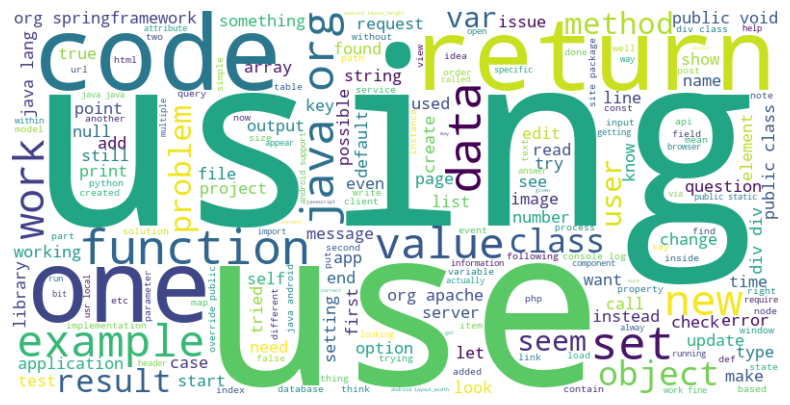

In [25]:
from wordcloud import WordCloud

# Combiner les textes de la colonne TitleBody_bow_lem
text = " ".join(data['TitleBody_bow_lem'].astype(str))

# Générer le nuage de mots
wordcloud = WordCloud(width=800, height=400, background_color ='white').generate(text)

# Afficher le nuage de mots
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [18]:
data.to_csv("dataclean.csv")